# Part 3
# Get the embedding for the title of the papers

In this section we will perform a common techique in NLP which consist in transform the text to a set of vectors each one representing a word inside a document. $\textit{Our goal is to transform the title of the papers into its embedding version}$. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of $n \times  m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents the word $n$.

In order to perform the embedding, a pre-trained model was used that is available in the followin link:

https://dl.fbaipublicfiles.com/fasttext/vectorswiki/wiki.en.vec

that consist of a set of pre-trained word vectors for 294 languages, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.


In [1]:
# Import packages
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from dask.distributed import Client, LocalCluster
from dask import delayed

import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.bag as db
import dask.dataframe as ddf
import os
import json
import numpy as np
import pandas as pd
import time

In order to load the vectors we made use of the gensim.models.KeyedVectors which is a module that implements word vectors and their similarity look-ups. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

In [3]:
#load the emmbeded words from pre-trained model
start=time.time()

word_vectors = KeyedVectors.load_word2vec_format('wiki.en.vec')
stop=time.time()

print("time(min):",(stop-start)/60)

time(min): 22.116703307628633


In [9]:
word_vectors['collection']

array([ 0.16487   , -0.37781   ,  0.10165   , -0.058655  ,  0.1567    ,
        0.55286   ,  0.2192    , -0.24161   ,  0.056417  ,  0.12307   ,
       -0.0021497 ,  0.3103    ,  0.034216  ,  0.0010884 , -0.43839   ,
       -0.42546   ,  0.31738   ,  0.29642   ,  0.16258   ,  0.11507   ,
       -0.048637  ,  0.13901   , -0.43144   ,  0.056601  ,  0.20591   ,
        0.12192   , -0.33687   ,  0.11246   ,  0.46472   , -0.063465  ,
       -0.29672   ,  0.39157   ,  0.069056  ,  0.19399   ,  0.34861   ,
       -0.21041   ,  0.071331  , -0.34916   , -0.043387  ,  0.08798   ,
        0.30783   , -0.21371   ,  0.01475   ,  0.040059  , -0.40749   ,
       -0.20512   , -0.027903  , -0.5183    ,  0.17494   ,  0.029446  ,
       -0.10412   , -0.069918  ,  0.15337   ,  0.12599   , -0.1029    ,
       -0.031872  ,  0.050948  , -0.073986  , -0.35038   ,  0.42087   ,
        0.070592  ,  0.055298  , -0.085695  ,  0.042058  , -0.058535  ,
        0.0089174 , -0.15605   , -0.11077   ,  0.012593  , -0.09

In [4]:
#client = Client('192.168.1.54:8786')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:62967 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 4.14 GB


We load the data given by creating a Dask Bag

In [6]:
b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=50)

In order to create a $Bag$ composed by:

    - paper-id
    - title-embedding
    
we create the function `flatten(record)` which will return the *paper_id* and *title* of all the articles and make use of the map function provided by Dask Bag. We also apply a filter in order to remove all the empty *title*.

In [7]:
def flatten(record):
    return {
        "paper_id": record['paper_id'],
        "title": record['metadata']['title']
            }

In [8]:
 # removing the papers that don't have titles
data = b.map(flatten).filter(lambda record: bool(record['title'])).compute()
       

Now we make use of the pre-trained model and create two functions:

 - `create_dictionary(dict, model)`: which creates a dictionary consist of the *paper_id* and the embedding *title*
 
 
 - `embedder(text, wiki)`: which takes the text of the title as input, lower case it (in the sense of converting all capital letter to small letter) and split it. Then apply the pre-trained model and convert each word into an np.array().
 
It should be notice that lowering the text was necesary since the 'wiki.en.vec' model is not able to detect Capital Letters. On the other hand, not all the words of the title were converted due to not being in the model.

In [9]:
def create_dictionary(dict, model):
    return{
        "paper_id": dict["paper_id"],
        "title": embedder(dict['title'], model)
    }

In [10]:
def embedder(text, wiki):
    text_split = text.lower().split() # we lower case all the words of the title to get a proper cosine similarity
    words_embedded=[]

    for words in text_split:
        try:
            words_embedded.append( wiki[words])
        except:
            pass
   
    return words_embedded

In [11]:
titles_embedded = [create_dictionary(datos,  word_vectors) for datos in data]

Convert list to dask bag using *db.from_sequence*

In [13]:
titles = db.from_sequence(titles_embedded)

In [14]:
titles.take(1)

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': [array([ 0.11559   ,  0.30192   , -0.11465   ,  0.01001   , -0.032187  ,
          -0.10755   ,  0.060674  , -0.10477   ,  0.17488   ,  0.0081116 ,
          -0.02263   ,  0.065401  ,  0.1133    ,  0.054737  , -0.06209   ,
          -0.029822  , -0.16608   ,  0.12224   ,  0.045251  ,  0.2134    ,
           0.027965  , -0.031319  , -0.25392   , -0.20146   , -0.19688   ,
          -0.015251  , -0.27038   ,  0.10511   ,  0.074226  ,  0.01554   ,
          -0.014038  ,  0.16516   , -0.17375   , -0.016743  ,  0.013919  ,
           0.01119   , -0.12599   , -0.11975   ,  0.079578  , -0.037088  ,
          -0.071665  , -0.085153  , -0.1117    ,  0.020142  , -0.161     ,
           0.0019132 ,  0.13843   ,  0.15445   , -0.026397  , -0.014582  ,
           0.00060368, -0.19382   ,  0.11267   ,  0.035035  , -0.014103  ,
           0.11427   , -0.093813  , -0.048103  , -0.0057412 ,  0.18635   ,
          -0.13767   , -0.25908  

# 3.3.1 Bonus point

We will now make used of the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

We first begin by defining the  `cosine_similarity ` function which basically computes the similarity between the texts as shown in the image.  

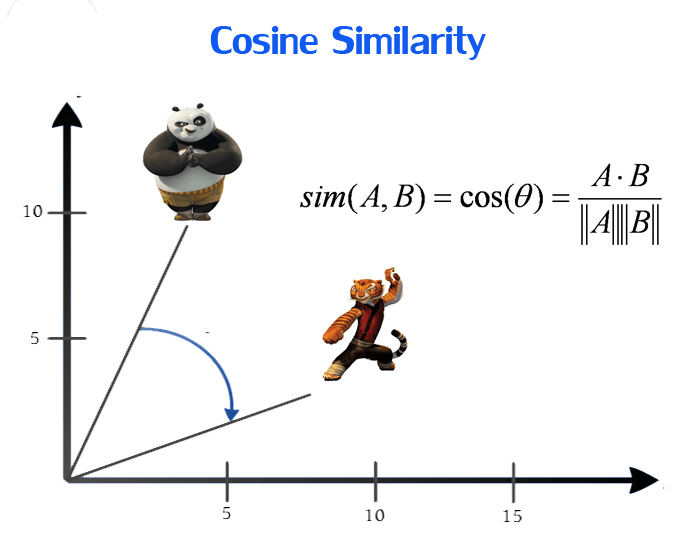

courtesy = https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

We compute the similarity word by word among the texts. When one of the text end, there's no more comparision. 

The function `similarity ` computes the similarity among two different sentence and return a dictionary. Finally we construct a similarity matrix.

In [14]:
def cosine_similarity(vec1, vec2):

    norm_vec1 = np.linalg.norm(vec1)   
    norm_vec2 =  np.linalg.norm(vec2)
    
    m = min(len(vec1), len(vec2)) # min of the length of either of two vectors is taken to compute inner product
    result = np.vdot(vec1[:m], vec2[:m])/(norm_vec1*norm_vec2)
    return result

In [16]:
def similarity(vec1, vec2):
    
    val = cosine_similarity(vec1['title'], vec2['title'])
    
    return{
        'paper 1': vec1['paper_id'],
        'paper 2' : vec2['paper_id'],
        'similarity' : val}

In [17]:
# Constructing a similarity matrix
dim = len(titles_embedded) # dimension of the matrix
sim_matrix = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        vec_i = titles_embedded[i]
        vec_j = titles_embedded[j]
        sim_matrix[i][j] = similarity(vec_i,vec_j)['similarity']

C:\Users\delfina\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Visualizing similarity matrix for all 901 papers that have titles


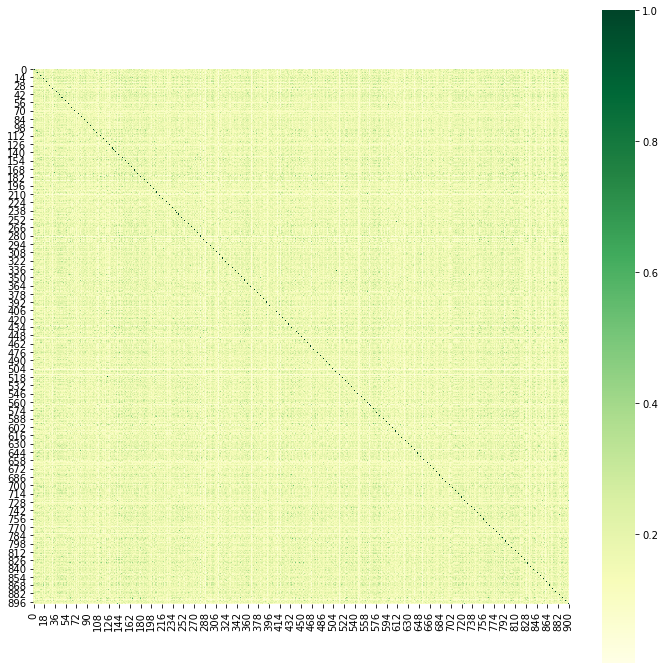

In [25]:
plt.figure(figsize=(12,12))
#ax = sns.heatmap(sim_matrix, vmin=-1, vmax=1, center=0, square=True)
sns.heatmap(sim_matrix, cmap="YlGn",square=True)
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()

Visualizing similarity for first 50 papers

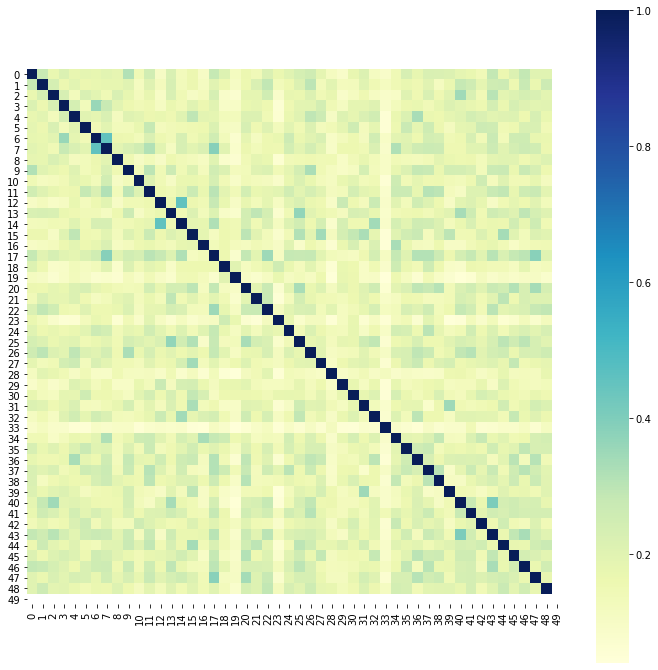

In [22]:
plt.figure(figsize=(12,12))

#ax = sns.heatmap(sim_matrix, vmin=-1, vmax=1, center=0, square=True)
sns.heatmap(sim_matrix[:50,:50], cmap="YlGnBu",square=True)
#sns.heatmap(sim_matrix,cmap=sns.diverging_palette(20, 220, n=200), square=True)
plt.show()

# We see from the visualization below that most papers don't go beyond 0.4 or 0.5 value of the cosine similarity
# metric.

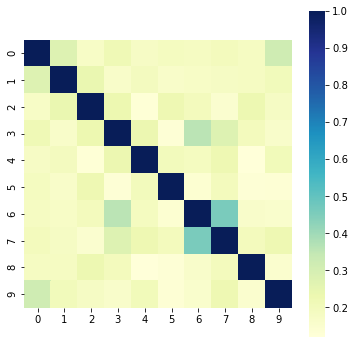

In [23]:
# similarity of first 10 papers to investigate cosine simiarity of paper6 and paper7
plt.figure(figsize=(6,6))
sns.heatmap(sim_matrix[:10,:10], cmap="YlGnBu",square=True)
plt.show()

In [24]:
# paper 7 and 6 seems to have some similarity, let's investigate.
print(data[6])
print(data[7])

# we can see that because of the words "respiratory" we get a little extra cosine similarity.
print("Cosine_simialrity Metric:",sim_matrix[6,7])

{'paper_id': '00a0ab182dc01b6c2e737dfae585f050dcf9a7a5', 'title': 'Middle East respiratory syndrome: An emerging coronavirus infection tracked by the crowd'}
{'paper_id': '00a3a4742c565f5e2e64ad03fe0f1e16baee89b3', 'title': 'Plethora of Respiratory Viruses and Respiratory Virus Data'}
Cosine_simialrity Metric: 0.45777037739753723


We create a data.frame and compute the time

In [26]:
start=time.time()

sim = []
for i in range(len(titles_embedded)):
    for j in range(i,len(titles_embedded)):
        if j == i: 
            pass
        else:
            try:
                sim.append(similarity(titles_embedded[i],titles_embedded[j]))
            except:
                pass

# Quantitatively checking which papers have common titles
df = pd.DataFrame(sim)

similar_papers = df.sort_values('similarity', ascending = False)
similar_papers = similar_papers.dropna()
similar_papers = similar_papers.reset_index(drop=True) # reset the index of df from 0 onwards for easy analysis
similar_papers

stop=time.time()
print("time(min):",(stop-start)/60)

time_np = (stop-start)/60)

C:\Users\delfina\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


time(min): 0.6281225959459941


Top 10 papers that have high cosine similarity

In [28]:
# Pandas querying: courtesy:https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe/36685531
total_data = pd.DataFrame.from_dict(data)
for i in range(10):
    paperid_1 = similar_papers['paper 1'][i]
    title1 = total_data.loc[ total_data['paper_id'] == similar_papers['paper 1'][i], "title" ].iloc[0]
    
    paperid_2 = similar_papers['paper 2'][i]
    title2 = total_data.loc[ total_data['paper_id'] == similar_papers['paper 2'][i], "title" ].iloc[0]
    
    cossim_value = similar_papers['similarity'][i]

    print("Paper 1: "+paperid_1+" Title: "+title1)
    print("Paper 2: "+paperid_2+" Title: "+title2)
    print("Cosine similarity:",cossim_value)
    print("\n")
#total_data["paper_id"]

Paper 1: 0ada158e5af242ffafe0c15d5af9d3c5f141e709 Title: Original Article
Paper 2: 0c41ec48ace1522ef6efb0deca6a6f2864213bb5 Title: Original Article
Cosine similarity: 0.9999999403953552


Paper 1: 0a4be9f048521079c802d449143d88bbb140c230 Title: To appear in: Public Health in Practice
Paper 2: 0bbfbaaf1a302da40204fe62e192ac839218b0e9 Title: To appear in: Public Health
Cosine similarity: 0.8508424162864685


Paper 1: 0a1ca73dc5f51aaecd0a451d8031316252603664 Title: RESPIRATORY VIRAL INFECTION AND ASTHMA
Paper 2: 0c916b643c9a58ad9c31e3674112c3309d191394 Title: Respiratory viral infections
Cosine similarity: 0.8382419347763062


Paper 1: 0b064096b51c4cada7b64af37eae826b7e7c9649 Title: Role of CD25 + CD4 + T cells in acute and persistent coronavirus infection of the central nervous system
Paper 2: 0bb97577b1f4c0a5f456ac10d593b4c46f285e9c Title: Role of CD25 þ CD4 þ T cells in acute and persistent coronavirus infection of the central nervous system
Cosine similarity: 0.8243870735168457


Pape

### Comparison of the numpy model against Dask Bag 

We will do the same thing as before but applying Dask Bag. In order to deal with this, we need to create a bag that contains the combination of the dataset.

In [12]:
def bag_similarity(record):
    
    val = cosine_similarity(record[0]['title'], record[1]['title'])
    return {
        "paper 1": record[0]['paper_id'],
        "paper 2": record[1]['paper_id'],
        "similarity": val
            }

In [15]:
data = db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(10) for j in range(i+1,10)]).repartition(8).map(bag_similarity).compute()
df = pd.DataFrame(data)
similar_papers = df.sort_values('similarity', ascending = False)
similar_papers = similar_papers.dropna()
similar_papers = similar_papers.reset_index(drop=True) # reset the index from 0 onwards for easy analysis
similar_papers.head()

,paper 1,paper 2,similarity
0,00a0ab182dc01b6c2e737dfae585f050dcf9a7a5,00a3a4742c565f5e2e64ad03fe0f1e16baee89b3,0.457770
1,000b7d1517ceebb34e1e3e817695b6de03e2fa78,00a0ab182dc01b6c2e737dfae585f050dcf9a7a5,0.358895
2,000a0fc8bbef80410199e690191dc3076a290117,00aa67f6695256f8ade032f62ea9fa2764d34a30,0.315974
3,000a0fc8bbef80410199e690191dc3076a290117,000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,0.276407
4,000b7d1517ceebb34e1e3e817695b6de03e2fa78,00a3a4742c565f5e2e64ad03fe0f1e16baee89b3,0.275918


We are facing the problem that it is not feasible to do it in this way. We are going to show that when the size of the combination increases it also does the time-

In [16]:
def bag_dimension(N):
    data = db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(N) for j in range(i+1,N)]).repartition(8).map(bag_similarity).compute()

In [17]:
ttime = []
for i in range(50):
    start=time.time()
    bag_dimension(i)
    stop=time.time()
    ttime.append((stop-start)/60)

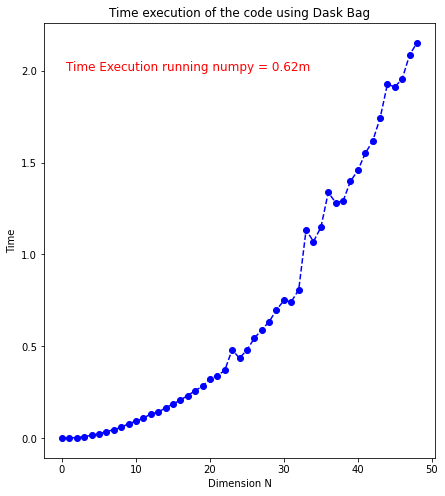

In [23]:
plt.figure(figsize=(7,8))
plt.plot(ttime[:49],  linestyle='--', marker='o', color='b')
plt.title('Time execution of the code using Dask Bag')
plt.xlabel('Dimension N')
plt.ylabel('Time')
plt.text(0.5, 2, 'Time Execution running numpy = 0.62m', fontsize=12, color = 'r')
plt.show()

As it can be seen from the above graph, running the code with numpy is much faster that creating the bag with all the combination of the papers (notice that in the graph we just consider 50 papers and we can already notice huge time difference, imagine the implementation time run through for all the papers!). Also, note that in the above graph, the execution time by using numpy is for all the combination of papers.